# Event Study

In [31]:
import pandas as pd 
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import warnings
warnings.filterwarnings('ignore')

### Data preprocessing
Get data; concat gold strategy and 6040 portfolio into one dataframe - use inner join

In [32]:
alternative_weight = 0.2 # Weight of alternative strat out of 1

gold_path = '../data/pnl_data/XAUBNG.csv'
base6040_path = '../data/pnl_data/60_40Ports.csv'
gold_pnl =  pd.read_csv(gold_path, index_col=0, parse_dates=['Date'])
base_pnl =  pd.read_csv(base6040_path, index_col=0, parse_dates=['Date'])
# display(gold_pnl.tail())
# display(base_pnl.tail())
pnl = pd.concat([base_pnl['ports_pctchange'].rename('6040 ret').to_frame(), gold_pnl['equity_change'].rename('Strategy ret').to_frame()], axis=1).dropna()

pnl[f'Combined (+{alternative_weight})'] = pnl['6040 ret'] + pnl['Strategy ret'] * alternative_weight
display(pnl)

,6040 ret,Strategy ret,Combined (+0.2)
Date,,,
1975-01-01,0.000000,0.000000,0.000000
1975-01-02,0.009743,0.000000,0.009743
1975-01-03,0.002734,0.000000,0.002734
1975-01-06,0.002036,0.000000,0.002036
1975-01-07,-0.000281,0.000000,-0.000281
...,...,...,...
2024-10-28,0.000266,-0.001856,-0.000105
2024-10-29,0.000981,0.011770,0.003335
2024-10-30,-0.001707,0.004638,-0.000780


### Get DD metric for 6040 port

In [33]:
pnl['6040 Equity'] = (1 + pnl['6040 ret']).cumprod()
pnl['Rolling Max'] = pnl['6040 Equity'].cummax()
pnl['Drawdown'] = (pnl['6040 Equity'] - pnl['Rolling Max'])/pnl['Rolling Max']
pnl['Drawdown'].tail()

Date
2024-10-28   -0.010243
2024-10-29   -0.009272
2024-10-30   -0.010963
2024-10-31   -0.018106
2024-11-01   -0.019243
Freq: B, Name: Drawdown, dtype: float64

### Get the periods when the Drawdown is above a threshold for a min number of days

In [34]:
threshold = -0.10
min_days = 14

pnl['below_threshold'] = pnl['Drawdown'] <= threshold
pnl['group'] = (pnl['below_threshold']!= pnl['below_threshold'].shift(1)).cumsum()
windows_dd = pnl[pnl['below_threshold']].groupby('group').apply(
    lambda x: pd.Series({'start': x.index[0], 'end': x.index[-1], 'duration':(x.index[-1] - x.index[0]).days + 1})
).reset_index(drop=True)
windows_dd = windows_dd[windows_dd['duration'] >= min_days]
windows_dd['event'] = windows_dd["start"].dt.strftime('%Y-%m') + " to " + windows_dd["end"].dt.strftime('%Y-%m')
windows_dd

,start,end,duration,event
2,1987-11-13,1987-12-15,33,1987-11 to 1987-12
9,2008-10-07,2008-12-15,70,2008-10 to 2008-12
11,2009-01-07,2009-07-15,190,2009-01 to 2009-07
15,2022-05-05,2022-05-26,22,2022-05 to 2022-05
16,2022-05-31,2022-07-28,59,2022-05 to 2022-07
20,2022-08-22,2023-06-01,284,2022-08 to 2023-06
24,2023-09-20,2023-11-13,55,2023-09 to 2023-11


### Get the periods specified as geopolitically relevant events

In [35]:
windows_events = [{'event': 'Apartheid Sanctions', 'start':'1986-09-01', 'end':'1988-09-01'},
                  {'event': 'Invasion of Kuwait', 'start':'1990-08-01', 'end':'1991-03-01'},
                  {'event': '9/11 Attacks', 'start':'2001-09-01', 'end':'2003-09-01'},
                  {'event': 'Iraq War', 'start':'2003-01-01', 'end':'2003-05-01'},
                  {'event': 'Lebanon War', 'start':'2006-07-01', 'end':'2006-10-01'},
                  {'event': 'Lehman Bankruptcy', 'start':'2007-12-01', 'end':'2009-07-01'},
                  {'event': 'Crimea Annexation', 'start':'2014-02-01', 'end':'2014-05-01'},
                  {'event': 'Ukraine Invasion', 'start':'2022-02-01', 'end':'2024-10-01'}]
windows_events = pd.DataFrame(windows_events)
windows_events['start'] = pd.to_datetime(windows_events['start'])
windows_events['end'] = pd.to_datetime(windows_events['end'])

# adjust dates to align with original data index
windows_events['start'] = pnl.index[pnl.index.get_indexer(windows_events['start'], method='nearest')]
windows_events['end'] = pnl.index[pnl.index.get_indexer(windows_events['end'], method='nearest')]
windows_events['duration'] = (windows_events['end']-windows_events['start']).dt.days
windows_events               

,event,start,end,duration
0,Apartheid Sanctions,1986-09-01,1988-09-01,731
1,Invasion of Kuwait,1990-08-01,1991-03-01,212
2,9/11 Attacks,2001-08-31,2003-09-01,731
3,Iraq War,2003-01-01,2003-05-01,120
4,Lebanon War,2006-06-30,2006-10-02,94
5,Lehman Bankruptcy,2007-11-30,2009-07-01,579
6,Crimea Annexation,2014-01-31,2014-05-01,90
7,Ukraine Invasion,2022-02-01,2024-10-01,973


### As a benchmark, get an understanding of historical correlation and performance


In [36]:
def get_metrics(data, days=None, plot=True, name = None):
    if not days:
        days = len(data)
    res = pd.DataFrame(index = data.columns)
    res['Annualized Mean'] = data.mean() * (252)
    res['Annualized Vol'] = data.std() * np.sqrt(252)
    res['Annualized Downside Vol'] = data[data<0].std() * np.sqrt(252)
    res['Annualized Sharpe'] = res['Annualized Mean']/res['Annualized Vol']
    res['Annualized Sortino'] = res['Annualized Mean']/res['Annualized Downside Vol']
    IS_corr = data.corr()
    IS_corr = data.corr().rename(columns = lambda c: f'{c} corr')
    if name:
        res.index.name = name
    if plot:
        figsize = (10, 6)
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(IS_corr, annot=True, cmap='coolwarm', ax=ax)
        plt.title(name if name else 'IS Correlation')
    res = pd.concat([res, IS_corr], axis=1)

    return res


In [37]:
display(pnl.iloc[0:3])
pnl = pnl[['6040 ret', 'Strategy ret', 'Combined (+0.2)']]


,6040 ret,Strategy ret,Combined (+0.2),6040 Equity,Rolling Max,Drawdown,below_threshold,group
Date,,,,,,,,
1975-01-01,0.000000,0.0,0.000000,1.000000,1.000000,0.0,False,1
1975-01-02,0.009743,0.0,0.009743,1.009743,1.009743,0.0,False,1
1975-01-03,0.002734,0.0,0.002734,1.012504,1.012504,0.0,False,1


,Annualized Mean,Annualized Vol,Annualized Downside Vol,Annualized Sharpe,Annualized Sortino,6040 ret corr,Strategy ret corr,Combined (+0.2) corr
6040 ret,0.076318,0.072612,0.053768,1.051033,1.419386,1.000000,0.005852,0.922525
Strategy ret,0.071359,0.152261,0.152681,0.468663,0.467375,0.005852,1.000000,0.391328
Combined (+0.2),0.090590,0.078903,0.057771,1.148108,1.568096,0.922525,0.391328,1.000000


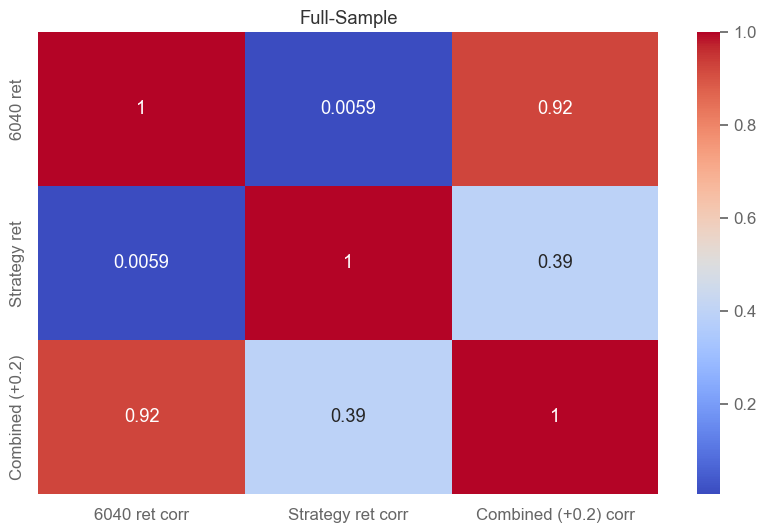

In [38]:
all_res = {}
res = get_metrics(pnl, plot=True, name='Full-Sample')
all_res['Full-sample'] = res
display(res)

### Conduct event study on windows


In [39]:
windows = pd.concat([windows_events, windows_dd], axis=0).reset_index(drop=True)
all_res['Full-sample']['event'] = 'Full-sample'


compiled_df = pd.DataFrame()
for idx,row in windows.iterrows():
    data = pnl.loc[row['start']:row['end']]
    all_res[row['event']] = get_metrics(data, name = row['event'], plot=False)
    all_res[row['event']]['event'] = row['event']
    compiled_df = pd.concat([compiled_df, all_res[row['event']]], axis=0)
compiled_df = compiled_df.reset_index().rename(columns={'index': 'Portfolio'})
compiled_df = compiled_df.set_index(['event', 'Portfolio'])

# split data driven and geopolitical
compiled_df_dd = compiled_df.loc[list(set([c for c,h in compiled_df.index if " to " in c]))]
compiled_df_geopolitical = compiled_df.loc[list(set([c for c,h in compiled_df.index if " to " not in c]))]
display(compiled_df_dd)
display(compiled_df_geopolitical)


Annualized Mean  Annualized Vol  \
event              Portfolio                                          
2008-10 to 2008-12 6040 ret               -0.136728        0.285730   
                   Strategy ret           -0.783944        0.266861   
                   Combined (+0.2)        -0.293517        0.285217   
2023-09 to 2023-11 6040 ret               -0.037765        0.083753   
                   Strategy ret            0.061465        0.141087   
                   Combined (+0.2)        -0.025472        0.087334   
1987-11 to 1987-12 6040 ret               -0.056252        0.113922   
                   Strategy ret            0.706065        0.178854   
                   Combined (+0.2)         0.084961        0.107668   
2022-05 to 2022-07 6040 ret               -0.029610        0.117103   
                   Strategy ret           -0.359251        0.127226   
                   Combined (+0.2)        -0.101460        0.126726   
2022-05 to 2022-05 6040 ret               -0.272362        0.117225   
                   Strategy ret           -0.249638        0.134008   
                   Combined (+0.2)        -0.322290        0.120187   
2009-01 to 2009-07 6040 ret               -0.013023        0.129443   
                   Strategy ret            0.099290        0.194407   
                   Combined (+0.2)         0.006835        0.133884   
2022-08 to 2023-06 6040 ret                0.000681        0.096844   
                   Strategy ret            0.056924        0.106023   
                   Combined (+0.2)         0.012066        0.101157   

                                    Annualized Downside Vol  \
event              Portfolio                                  
2008-10 to 2008-12 6040 ret                        0.149996   
                   Strategy ret                    0.298409   
                   Combined (+0.2)                 0.145196   
2023-09 to 2023-11 6040 ret                        0.052133   
                   Strategy ret                    0.058892   
                   Combined (+0.2)                 0.049311   
1987-11 to 1987-12 6040 ret                        0.067432   
                   Strategy ret                    0.175695   
                   Combined (+0.2)                 0.063061   
2022-05 to 2022-07 6040 ret                        0.084859   
                   Strategy ret                    0.124844   
                   Combined (+0.2)                 0.092933   
2022-05 to 2022-05 6040 ret                        0.107089   
                   Strategy ret                    0.089980   
                   Combined (+0.2)                 0.109805   
2009-01 to 2009-07 6040 ret                        0.073996   
                   Strategy ret                    0.121860   
                   Combined (+0.2)                 0.069218   
2022-08 to 2023-06 6040 ret                        0.056723   
                   Strategy ret                    0.091893   
                   Combined (+0.2)                 0.059287   

                                    Annualized Sharpe  Annualized Sortino  \
event              Portfolio                                                
2008-10 to 2008-12 6040 ret                 -0.478523           -0.911544   
                   Strategy ret             -2.937644           -2.627079   
                   Combined (+0.2)          -1.029100           -2.021520   
2023-09 to 2023-11 6040 ret                 -0.450915           -0.724411   
                   Strategy ret              0.435654            1.043691   
                   Combined (+0.2)          -0.291666           -0.516567   
1987-11 to 1987-12 6040 ret                 -0.493778           -0.834210   
                   Strategy ret              3.947727            4.018703   
                   Combined (+0.2)           0.789099            1.347277   
2022-05 to 2022-07 6040 ret                 -0.252855           -0.348933   
                   Strategy 

Annualized Mean  Annualized Vol  \
event               Portfolio                                          
Lehman Bankruptcy   6040 ret               -0.052645        0.139256   
                    Strategy ret            0.007108        0.244861   
                    Combined (+0.2)        -0.051223        0.140773   
Iraq War            6040 ret                0.083270        0.072702   
                    Strategy ret           -0.035326        0.188306   
                    Combined (+0.2)         0.076205        0.066255   
Ukraine Invasion    6040 ret                0.034025        0.084227   
                    Strategy ret            0.119558        0.125846   
                    Combined (+0.2)         0.057936        0.091839   
9/11 Attacks        6040 ret                0.023265        0.083819   
                    Strategy ret            0.161472        0.151419   
                    Combined (+0.2)         0.055559        0.081241   
Lebanon War         6040 ret                0.161243        0.043995   
                    Strategy ret            0.004705        0.216839   
                    Combined (+0.2)         0.162184        0.064257   
Crimea Annexation   6040 ret                0.097382        0.041495   
                    Strategy ret            0.000000        0.000000   
                    Combined (+0.2)         0.097382        0.041495   
Invasion of Kuwait  6040 ret                0.097644        0.083053   
                    Strategy ret           -0.165270        0.128126   
                    Combined (+0.2)         0.064590        0.083644   
Apartheid Sanctions 6040 ret                0.037639        0.108059   
                    Strategy ret            0.074010        0.160626   
                    Combined (+0.2)         0.052441        0.107663   

                                     Annualized Downside Vol  \
event               Portfolio                                  
Lehman Bankruptcy   6040 ret                        0.098010   
                    Strategy ret                    0.181539   
                    Combined (+0.2)                 0.097597   
Iraq War            6040 ret                        0.041431   
                    Strategy ret                    0.132441   
                    Combined (+0.2)                 0.040918   
Ukraine Invasion    6040 ret                        0.057665   
                    Strategy ret                    0.093910   
                    Combined (+0.2)                 0.062176   
9/11 Attacks        6040 ret                        0.051814   
                    Strategy ret                    0.100706   
                    Combined (+0.2)                 0.051693   
Lebanon War         6040 ret                        0.021897   
                    Strategy ret                    0.151446   
                    Combined (+0.2)                 0.036817   
Crimea Annexation   6040 ret                        0.029952   
                    Strategy ret                         NaN   
                    Combined (+0.2)                 0.029952   
Invasion of Kuwait  6040 ret                        0.045908   
                    Strategy ret                    0.249878   
                    Combined (+0.2)                 0.049678   
Apartheid Sanctions 6040 ret                        0.106195   
                    Strategy ret                    0.121534   
                    Combined (+0.2)                 0.100542   

                                     Annualized Sharpe  Annualized Sortino  \
event               Portfolio                                                
Lehman Bankruptcy   6040 ret                 -0.378044           -0.537141   
                    Strategy ret              0.029027            0.039151   
                    Combined (+0.2)          -0.363873           -0.524848   
Iraq War            6040 ret                  1.145358            2.009829   
                    Strategy re

In [40]:
correlations = pd.DataFrame(index = all_res.keys())
correlations['Alternative Strategy correlation w/ 6040'] = None
for event in all_res.keys():
    correlations.loc[event, 'Alternative Strategy correlation w/ 6040'] = all_res[event].loc['6040 ret', 'Strategy ret corr']
correlations = correlations.applymap(lambda x: np.nan if pd.isna(x) else f'{x*100:.2f}%')
correlations.rename_axis('event', axis=0, inplace=True)
windows.set_index('event', inplace=True)

In [41]:
correlations = pd.concat([correlations, windows], axis=1)
correlations.loc['Full-sample', ['start', 'end', 'duration']] = [pnl.index[0], pnl.index[-1], (pnl.index[-1]-pnl.index[0]).days+1]
correlations


,Alternative Strategy correlation w/ 6040,start,end,duration
event,,,,
Full-sample,0.59%,1975-01-01,2024-11-01,18203.0
Apartheid Sanctions,-16.09%,1986-09-01,1988-09-01,731.0
Invasion of Kuwait,-13.11%,1990-08-01,1991-03-01,212.0
9/11 Attacks,-26.45%,2001-08-31,2003-09-01,731.0
Iraq War,-42.26%,2003-01-01,2003-05-01,120.0
Lebanon War,8.19%,2006-06-30,2006-10-02,94.0
Lehman Bankruptcy,-14.47%,2007-11-30,2009-07-01,579.0
Crimea Annexation,NaN,2014-01-31,2014-05-01,90.0
Ukraine Invasion,16.67%,2022-02-01,2024-10-01,973.0


### On a rolling correlation plot, highlight periods above

2023-09 to 2023-11,Strategy ret,Combined (+0.2)
Date,,
1975-01-01,0.000000,0.000000
1975-01-02,0.000000,0.009743
1975-01-03,0.000000,0.002734
1975-01-06,0.000000,0.002036
1975-01-07,0.000000,-0.000281
...,...,...
2024-10-28,-0.001856,-0.000105
2024-10-29,0.011770,0.003335
2024-10-30,0.004638,-0.000780


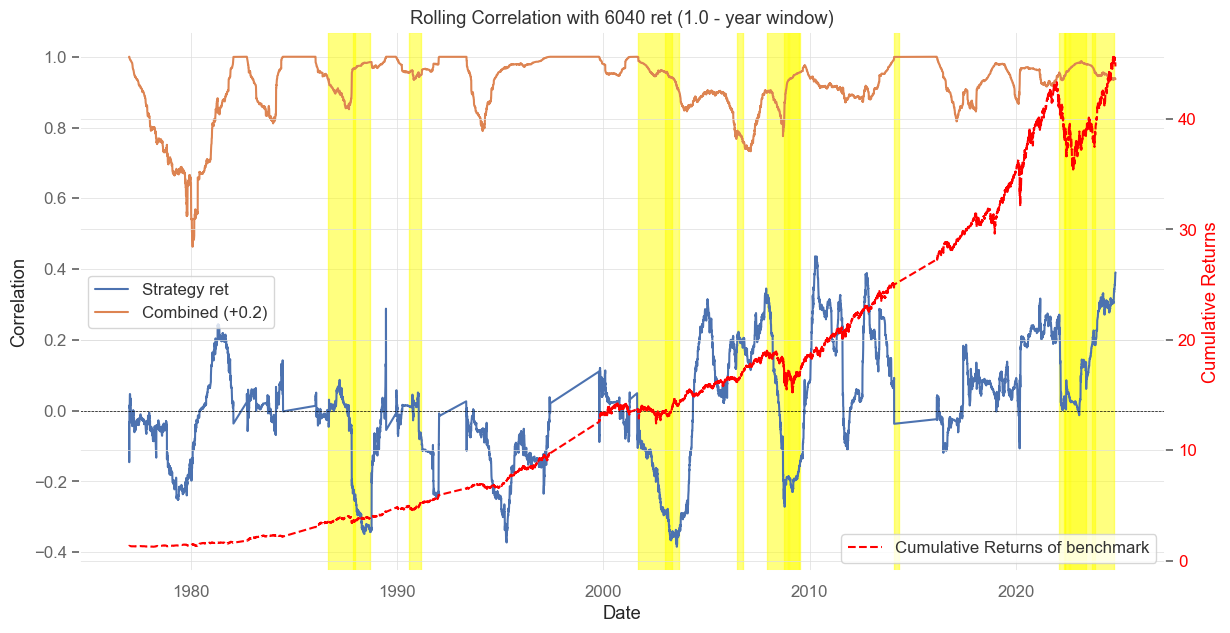

2023-09 to 2023-11,Strategy ret,Combined (+0.2)
Date,,
1976-12-30,-0.031881,1.000000
1976-12-31,-0.145333,0.999973
1977-01-03,-0.145356,0.999973
1977-01-04,-0.131611,0.999360
1977-01-05,0.015093,0.996398
...,...,...
2024-10-28,0.372365,0.937799
2024-10-29,0.383306,0.938313
2024-10-30,0.382319,0.938266


In [47]:
from metrics import calc_rolling_corr
highlight_regions = list(zip(correlations['start'][1:], correlations['end'][1:]))
display(pnl.iloc[:,1:])
calc_rolling_corr(pnl['6040 ret'], pnl[['Strategy ret', 'Combined (+0.2)']], window_size=252, highlight_regions=highlight_regions)